In [1]:
#import torch
import os, sys, re, time
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
#import torch
print(os.getpid())
sys.path.append(r"/lab/weissman_imaging/puzheng/Softwares")

459063


In [2]:
import cv2
from ChromAn.src.file_io.data_organization import search_fovs_in_folders, Color_Usage
from ChromAn.src.segmentation_tools.cells import Align_Segmentation

In [3]:
import merlin
from merlin.util import watershed
from scipy import ndimage
from skimage import morphology
from skimage import segmentation
from copy import copy

In [4]:
# Cellpose 
from cellpose import models

## Folders

In [7]:
# data_folder
data_folder = r'/lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified'
# correction
correction_folder = r'/lab/weissman_imaging/puzheng/Corrections/20230824-Merscope01'

segmentation_save_folder = os.path.join(data_folder, 'Segmentation')
if not os.path.exists(segmentation_save_folder):
    print(segmentation_save_folder)
    os.makedirs(segmentation_save_folder)
watershed_folder = os.path.join(segmentation_save_folder, 'watershed')
if not os.path.exists(watershed_folder):
    print(watershed_folder)
    os.makedirs(watershed_folder)

/lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/Segmentation
/lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/Segmentation/watershed


In [8]:
# transpose with microscope
parameter_folder = r'/lab/weissman_imaging/puzheng/Softwares/Weissman_MERFISH_Scripts/merlin_parameters'
microscope_file = os.path.join(parameter_folder, 'microscope', 'merscope01_microscope.json')
microscope_params = Align_Segmentation._read_microscope_json(microscope_file)
microscope_params

{'flip_horizontal': False,
 'flip_vertical': True,
 'transpose': True,
 'microns_per_pixel': 0.107,
 'image_dimensions': [2304, 2304]}

In [9]:
# search folders
folders, fovs = search_fovs_in_folders(data_folder)
# Color usage file marks the organization of imaging files
color_usage_filename = os.path.join(data_folder, 'Analysis', 'color_usage_MF5_amplified.csv')
color_usage_df = Color_Usage(color_usage_filename)

- searching in folder: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified
-- 9 folders, 335 fovs detected.
- load color_usage from file: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/Analysis/color_usage_MF5_amplified.csv


In [10]:
# from color_usage, find dapi / polyt / fiducial
dapi_info = color_usage_df.get_dapi_info()[0]
polyt_info = color_usage_df.get_polyt_info()[0]
fiducial_channel = color_usage_df.get_fiducial_channel(color_usage_df)
print(dapi_info, polyt_info, fiducial_channel)

{'hyb': 'H0M1', 'channel': '405'} {'channel': '637', 'hyb': 'H8M9'} 477


# Run segmentation

In [11]:
from ChromAn.src.file_io.dax_process import DaxProcesser
from ChromAn.src.visual_tools.interactive import imshow_mark_3d
from merlin.analysis.segment import CellPoseSegment

In [12]:
from importlib import reload

In [13]:
import ChromAn
reload(ChromAn.src.file_io.dax_process)

<module 'ChromAn.src.file_io.dax_process' from '/lab/weissman_imaging/puzheng/Softwares/ChromAn/src/file_io/dax_process.py'>

In [22]:

for _fov_id, _fov_name in enumerate(fovs):


    _save_id = _fov_id 
    seg_save_file = os.path.join(segmentation_save_folder, f'segmentation_label_{_save_id}.npy')
    if os.path.exists(seg_save_file):
        print(f"Segmentation label file: {seg_save_file} already exists, skip")
        continue
    
    ref_image_file = os.path.join(data_folder, dapi_info['hyb'], _fov_name)
    polyt_image_file = os.path.join(data_folder, polyt_info['hyb'], _fov_name)
    print(f"reference image: {ref_image_file}")
    print(f"PolyT and DAPI image: {polyt_image_file}")
    # load reference DAPI
    _ref_cls = DaxProcesser(ref_image_file, CorrectionFolder=correction_folder, 
                            FiducialChannel=fiducial_channel, DapiChannel=dapi_info['channel'])
    _ref_cls._load_image(sel_channels=[fiducial_channel,dapi_info['channel']])
    #_ref_cls._corr_illumination()
    _ref_im = getattr(_ref_cls, f'im_{fiducial_channel}')
    
    # load polyT and DAPI
    _cls = DaxProcesser(polyt_image_file, CorrectionFolder=correction_folder, 
                        FiducialChannel=fiducial_channel)
    _cls._load_image(sel_channels=[polyt_info['channel'],fiducial_channel])
    _cls.ref_correction_channel = '637'
    #_cls._corr_illumination()
    _cls._calculate_drift(_ref_im, )
    _cls._corr_warpping_drift_chromatic(correction_channels=[polyt_info['channel']], corr_chromatic=False) # removed 405 to increase efficiency
    
    _dapi_im = getattr(_ref_cls, f"im_{dapi_info['channel']}")
    _polyt_im = getattr(_cls, f"im_{polyt_info['channel']}")
    # Run segmentation if target file not exist:
    if os.path.isfile(seg_save_file):
        print(f"- directly load seg from: {seg_save_file}")
        corr_labels3d = np.load(seg_save_file)
    else:
        print(f"- apply microscope corrections")
        dapi_im = Align_Segmentation._correct_image3D_by_microscope_param(_dapi_im, microscope_params)
        polyt_im = Align_Segmentation._correct_image3D_by_microscope_param(_polyt_im, microscope_params)

        # Create cellpose model
        print(f"- run Cellpose segmentation", end=' ')
        _cellpose_start = time.time()
        seg_model = models.CellposeModel(gpu=True, model_type='TN2')
        # Run cellpose prediction
        labels3d, _, _ = seg_model.eval(np.stack([polyt_im, dapi_im], axis=3), 
                                        #batch_size=60, #anisotropy=250/108,
                                        anisotropy=1000/108,
                                        cellprob_threshold=0, 
                                        channels=[1,2], 
                                        diameter=50, 
                                        min_size=2000,
                                        do_3D=False,
                                        )
        print(f"in {time.time()-_cellpose_start:.3f}s.")

        # convert to corrected labels
        corr_labels3d = CellPoseSegment.combine_2d_segmentation_masks_into_3d(labels3d)

        # save this segmentation mask
        print(f"- save to {np.max(corr_labels3d)} labels to file: {seg_save_file}")
        np.save(seg_save_file.split('.npy')[0], corr_labels3d, )
    
    

Segmentation label file: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/Segmentation/segmentation_label_0.npy already exists, skip
Segmentation label file: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/Segmentation/segmentation_label_1.npy already exists, skip
reference image: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_002.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_002.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_002.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_002_processed.hdf5
-- all used channels: ['748', '637', '545', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 

- Loaded images for channels:['637', '477'] in 1.513s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.01  0.76 -1.65] in 0.592s.
-- drift 1: [-0.01  0.77 -1.59] in 0.446s.
-- drift 2: [ 0.    0.75 -1.71] in 0.448s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.620s.
- Finished warp correction in 8.620s.
- apply microscope corrections
- run Cellpose segmentation in 34.576s.
- save to 116 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/Segmentation/segmentation_label_6.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_007.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_007.dax

- Loaded images for channels:['477', '405'] in 2.645s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_011.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_011_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.337s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.01  0.57 -1.41] in 0.585s.
-- drift 1: [ 0.    0.59 -1.37] in 0.457s.
-- drift 2: [-0.01  0.58 -1.41] in 0.452s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.628s.
- Finished warp correction in 8.628s.
- apply microscope corrections
- run Cellpose segmentation in 36.21

reference image: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_016.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_016.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_016.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_016_processed.hdf5
-- all used channels: ['748', '637', '545', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 2.662s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_016.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_016_processed.hdf5
-- all used channels: ['637', '477']
-- single imag

- Loaded images for channels:['477', '405'] in 2.477s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_020.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_020_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.258s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ 0.   -0.39 -0.62] in 0.590s.
-- drift 1: [ 0.   -0.58 -0.73] in 0.437s.
-- drift 2: [ 0.   -0.48 -0.63] in 0.443s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.650s.
- Finished warp correction in 8.650s.
- apply microscope corrections
- run Cellpose segmentation in 33.95

reference image: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_025.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_025.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_025.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_025_processed.hdf5
-- all used channels: ['748', '637', '545', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 2.247s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_025.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_025_processed.hdf5
-- all used channels: ['637', '477']
-- single imag

-- drift 0: [0.   1.6  0.68] in 0.574s.
-- drift 1: [0.   1.51 0.7 ] in 0.441s.
-- drift 2: [0.   1.49 0.81] in 0.444s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.607s.
- Finished warp correction in 8.607s.
- apply microscope corrections
- run Cellpose segmentation in 36.683s.
- save to 122 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/Segmentation/segmentation_label_29.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_030.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_030.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_030.dax
- New save file: /lab/weissman_

- Loaded images for channels:['477', '405'] in 2.256s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_034.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_034_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.469s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [0.   2.71 1.92] in 0.585s.
-- drift 1: [0.   2.71 1.9 ] in 0.435s.
-- drift 2: [0.   2.67 1.92] in 0.442s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.597s.
- Finished warp correction in 8.597s.
- apply microscope corrections
- run Cellpose segmentation in 36.539s.
- sav

reference image: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_039.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_039.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_039.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_039_processed.hdf5
-- all used channels: ['748', '637', '545', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 2.512s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_039.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_039_processed.hdf5
-- all used channels: ['637', '477']
-- single imag

-- drift 0: [-0.01 -0.25 -2.35] in 0.580s.
-- drift 1: [-0.01 -0.32 -2.34] in 0.432s.
-- drift 2: [-0.01 -0.29 -2.31] in 0.437s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.625s.
- Finished warp correction in 8.626s.
- apply microscope corrections
- run Cellpose segmentation in 36.662s.
- save to 167 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/Segmentation/segmentation_label_43.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_044.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_044.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_044.dax
- New save file: /lab/

- Loaded images for channels:['477', '405'] in 2.979s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_048.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_048_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.355s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ 0.   0.2 -1. ] in 0.605s.
-- drift 1: [ 0.    0.21 -1.02] in 0.453s.
-- drift 2: [ 0.    0.2  -1.11] in 0.454s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.680s.
- Finished warp correction in 8.680s.
- apply microscope corrections
- run Cellpose segmentation in 36.032s.

reference image: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_053.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_053.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_053.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_053_processed.hdf5
-- all used channels: ['748', '637', '545', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 2.407s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_053.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_053_processed.hdf5
-- all used channels: ['637', '477']
-- single imag

-- drift 0: [-0.01  0.81 -0.56] in 0.594s.
-- drift 1: [ 0.    0.77 -0.63] in 0.448s.
-- drift 2: [ 0.    0.74 -0.56] in 0.447s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.689s.
- Finished warp correction in 8.689s.
- apply microscope corrections
- run Cellpose segmentation in 36.754s.
- save to 121 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/Segmentation/segmentation_label_57.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_058.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_058.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_058.dax
- New save file: /lab/

- Loaded images for channels:['477', '405'] in 2.334s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_062.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_062_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.252s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [0.   1.03 0.43] in 0.572s.
-- drift 1: [0.   1.01 0.44] in 0.444s.
-- drift 2: [0.   1.04 0.47] in 0.455s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.646s.
- Finished warp correction in 8.646s.
- apply microscope corrections
- run Cellpose segmentation in 36.276s.
- sav

reference image: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_067.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_067.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_067.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_067_processed.hdf5
-- all used channels: ['748', '637', '545', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 2.587s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_067.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_067_processed.hdf5
-- all used channels: ['637', '477']
-- single imag

-- drift 0: [-0.01 -0.29 -0.81] in 0.592s.
-- drift 1: [-0.01 -0.29 -0.72] in 0.437s.
-- drift 2: [-0.01 -0.31 -0.73] in 0.448s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.637s.
- Finished warp correction in 8.637s.
- apply microscope corrections
- run Cellpose segmentation in 39.176s.
- save to 186 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/Segmentation/segmentation_label_71.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_072.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_072.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_072.dax
- New save file: /lab/

- Loaded images for channels:['477', '405'] in 2.177s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_076.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_076_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.060s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.01  0.78 -1.31] in 0.592s.
-- drift 1: [-0.01  0.75 -1.2 ] in 0.440s.
-- drift 2: [-0.01  0.72 -1.19] in 0.446s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.668s.
- Finished warp correction in 8.668s.
- apply microscope corrections
- run Cellpose segmentation in 37.49

reference image: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_081.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_081.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_081.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_081_processed.hdf5
-- all used channels: ['748', '637', '545', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 2.829s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_081.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_081_processed.hdf5
-- all used channels: ['637', '477']
-- single imag

-- drift 0: [0.   0.99 0.18] in 0.500s.
-- drift 1: [0.   1.02 0.27] in 0.416s.
-- drift 2: [0.   0.98 0.12] in 0.407s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.655s.
- Finished warp correction in 8.655s.
- apply microscope corrections
- run Cellpose segmentation in 35.075s.
- save to 125 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/Segmentation/segmentation_label_85.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_086.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_086.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_086.dax
- New save file: /lab/weissman_

- Loaded images for channels:['477', '405'] in 2.412s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_090.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_090_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.061s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ 0.    1.92 -0.45] in 0.605s.
-- drift 1: [ 0.    1.89 -0.42] in 0.449s.
-- drift 2: [ 0.    1.9  -0.44] in 0.454s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.654s.
- Finished warp correction in 8.654s.
- apply microscope corrections
- run Cellpose segmentation in 37.30

reference image: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_095.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_095.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_095.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_095_processed.hdf5
-- all used channels: ['748', '637', '545', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 2.458s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_095.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_095_processed.hdf5
-- all used channels: ['637', '477']
-- single imag

-- drift 0: [-0.01  1.41 -2.24] in 0.590s.
-- drift 1: [ 0.    1.43 -2.28] in 0.438s.
-- drift 2: [-0.01  1.47 -2.26] in 0.442s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.643s.
- Finished warp correction in 8.643s.
- apply microscope corrections
- run Cellpose segmentation in 34.218s.
- save to 124 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/Segmentation/segmentation_label_99.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_100.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_100.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_100.dax
- New save file: /lab/

- Loaded images for channels:['477', '405'] in 2.314s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_104.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_104_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.182s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.01  0.9  -1.08] in 0.553s.
-- drift 1: [ 0.    0.88 -1.07] in 0.453s.
-- drift 2: [ 0.    0.92 -1.1 ] in 0.441s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.637s.
- Finished warp correction in 8.637s.
- apply microscope corrections
- run Cellpose segmentation in 34.31

reference image: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_109.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_109.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_109.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_109_processed.hdf5
-- all used channels: ['748', '637', '545', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 2.178s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_109.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_109_processed.hdf5
-- all used channels: ['637', '477']
-- single imag

-- drift 0: [-0.02  0.2  -0.98] in 0.587s.
-- drift 1: [ 0.    0.23 -1.03] in 0.433s.
-- drift 2: [-0.01  0.36 -1.15] in 0.442s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.701s.
- Finished warp correction in 8.702s.
- apply microscope corrections
- run Cellpose segmentation in 35.033s.
- save to 135 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/Segmentation/segmentation_label_113.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_114.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_114.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_114.dax
- New save file: /lab

- Loaded images for channels:['477', '405'] in 2.767s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_118.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_118_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.109s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ 0.    0.03 -3.53] in 0.527s.
-- drift 1: [-0.01  0.11 -3.58] in 0.419s.
-- drift 2: [ 0.    0.03 -3.56] in 0.409s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.699s.
- Finished warp correction in 8.699s.
- apply microscope corrections
- run Cellpose segmentation in 34.99

reference image: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_123.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_123.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_123.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_123_processed.hdf5
-- all used channels: ['748', '637', '545', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 2.403s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_123.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_123_processed.hdf5
-- all used channels: ['637', '477']
-- single imag

-- drift 0: [-0.01  0.14 -1.56] in 0.425s.
-- drift 1: [-0.01  0.18 -1.57] in 0.440s.
-- drift 2: [-0.01  0.15 -1.56] in 0.438s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.631s.
- Finished warp correction in 8.631s.
- apply microscope corrections
- run Cellpose segmentation in 34.609s.
- save to 96 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/Segmentation/segmentation_label_127.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_128.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_128.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_128.dax
- New save file: /lab/

- Loaded images for channels:['477', '405'] in 2.356s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_132.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_132_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.295s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ 0.    0.52 -1.66] in 0.597s.
-- drift 1: [ 0.    0.43 -1.67] in 0.445s.
-- drift 2: [ 0.    0.49 -1.64] in 0.452s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.635s.
- Finished warp correction in 8.635s.
- apply microscope corrections
- run Cellpose segmentation in 32.25

reference image: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_137.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_137.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_137.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_137_processed.hdf5
-- all used channels: ['748', '637', '545', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 2.455s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_137.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_137_processed.hdf5
-- all used channels: ['637', '477']
-- single imag

-- drift 0: [ 0.    0.41 -0.42] in 0.608s.
-- drift 1: [ 0.    0.36 -0.48] in 0.447s.
-- drift 2: [ 0.    0.39 -0.45] in 0.453s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.781s.
- Finished warp correction in 8.781s.
- apply microscope corrections
- run Cellpose segmentation in 36.543s.
- save to 150 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/Segmentation/segmentation_label_141.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_142.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_142.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_142.dax
- New save file: /lab

- Loaded images for channels:['477', '405'] in 2.376s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_146.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_146_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.154s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ 0.    0.4  -0.03] in 0.577s.
-- drift 1: [-0.01  0.39 -0.04] in 0.424s.
-- drift 2: [ 0.    0.41 -0.02] in 0.446s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.633s.
- Finished warp correction in 8.633s.
- apply microscope corrections
- run Cellpose segmentation in 40.28

reference image: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_151.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_151.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_151.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_151_processed.hdf5
-- all used channels: ['748', '637', '545', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 2.459s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_151.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_151_processed.hdf5
-- all used channels: ['637', '477']
-- single imag

-- drift 0: [-0.01  0.96 -2.69] in 0.579s.
-- drift 1: [ 0.    0.97 -2.67] in 0.430s.
-- drift 2: [-0.01  0.95 -2.64] in 0.439s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.646s.
- Finished warp correction in 8.646s.
- apply microscope corrections
- run Cellpose segmentation in 36.201s.
- save to 119 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/Segmentation/segmentation_label_155.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_156.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_156.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_156.dax
- New save file: /lab

- Loaded images for channels:['477', '405'] in 2.841s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_160.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_160_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.144s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.01  0.07 -3.39] in 0.578s.
-- drift 1: [ 0.    0.02 -3.35] in 0.426s.
-- drift 2: [ 0.    0.04 -3.36] in 0.436s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.623s.
- Finished warp correction in 8.623s.
- apply microscope corrections
- run Cellpose segmentation in 30.35

reference image: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_165.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_165.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_165.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_165_processed.hdf5
-- all used channels: ['748', '637', '545', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 2.310s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_165.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_165_processed.hdf5
-- all used channels: ['637', '477']
-- single imag

-- drift 0: [ 0.    1.16 -0.93] in 0.594s.
-- drift 1: [-0.01  1.2  -0.97] in 0.436s.
-- drift 2: [-0.01  1.15 -0.86] in 0.443s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.633s.
- Finished warp correction in 8.633s.
- apply microscope corrections
- run Cellpose segmentation in 34.819s.
- save to 152 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/Segmentation/segmentation_label_169.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_170.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_170.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_170.dax
- New save file: /lab

- Loaded images for channels:['477', '405'] in 2.615s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_174.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_174_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.145s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ 0.    0.46 -0.1 ] in 0.584s.
-- drift 1: [ 0.    0.42 -0.1 ] in 0.438s.
-- drift 2: [ 0.    0.56 -0.07] in 0.447s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.645s.
- Finished warp correction in 8.645s.
- apply microscope corrections
- run Cellpose segmentation in 37.15

reference image: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_179.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_179.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_179.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_179_processed.hdf5
-- all used channels: ['748', '637', '545', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 2.444s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_179.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_179_processed.hdf5
-- all used channels: ['637', '477']
-- single imag

-- drift 0: [-0.02 -0.29 -2.45] in 0.587s.
-- drift 1: [-0.01 -0.42 -2.42] in 0.444s.
-- drift 2: [-0.02 -0.28 -2.44] in 0.448s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.667s.
- Finished warp correction in 8.667s.
- apply microscope corrections
- run Cellpose segmentation in 34.754s.
- save to 130 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/Segmentation/segmentation_label_183.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_184.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_184.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_184.dax
- New save file: /lab

- Loaded images for channels:['477', '405'] in 2.459s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_188.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_188_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.189s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [0.   0.77 0.82] in 0.577s.
-- drift 1: [0.   0.77 0.83] in 0.441s.
-- drift 2: [0.  0.8 0.8] in 0.447s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.643s.
- Finished warp correction in 8.643s.
- apply microscope corrections
- run Cellpose segmentation in 35.030s.
- save t

reference image: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_193.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_193.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_193.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_193_processed.hdf5
-- all used channels: ['748', '637', '545', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 2.905s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_193.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_193_processed.hdf5
-- all used channels: ['637', '477']
-- single imag

-- drift 0: [-0.01  1.1  -0.9 ] in 0.587s.
-- drift 1: [ 0.    0.89 -0.81] in 0.436s.
-- drift 2: [ 0.    1.06 -0.88] in 0.445s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.763s.
- Finished warp correction in 8.763s.
- apply microscope corrections
- run Cellpose segmentation in 30.867s.
- save to 31 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/Segmentation/segmentation_label_197.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_198.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_198.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_198.dax
- New save file: /lab/

- Loaded images for channels:['477', '405'] in 2.542s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_202.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_202_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.186s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.01  0.53 -0.55] in 0.593s.
-- drift 1: [ 0.    0.6  -0.63] in 0.431s.
-- drift 2: [ 0.    0.63 -0.57] in 0.440s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.613s.
- Finished warp correction in 8.613s.
- apply microscope corrections
- run Cellpose segmentation in 36.72

reference image: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_207.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_207.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_207.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_207_processed.hdf5
-- all used channels: ['748', '637', '545', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 2.584s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_207.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_207_processed.hdf5
-- all used channels: ['637', '477']
-- single imag

-- drift 0: [ 0.    0.58 -1.06] in 0.608s.
-- drift 1: [ 0.    0.58 -1.11] in 0.450s.
-- drift 2: [ 0.    0.59 -1.07] in 0.455s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.661s.
- Finished warp correction in 8.661s.
- apply microscope corrections
- run Cellpose segmentation in 36.105s.
- save to 140 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/Segmentation/segmentation_label_211.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_212.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_212.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_212.dax
- New save file: /lab

- Loaded images for channels:['477', '405'] in 2.339s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_216.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_216_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.122s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ 0.    0.02 -1.03] in 0.603s.
-- drift 1: [ 0.  0. -1.] in 0.453s.
-- drift 2: [ 0.   -0.03 -1.02] in 0.450s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.635s.
- Finished warp correction in 8.635s.
- apply microscope corrections
- run Cellpose segmentation in 35.201s.
- 

reference image: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_221.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_221.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_221.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_221_processed.hdf5
-- all used channels: ['748', '637', '545', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 2.410s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_221.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_221_processed.hdf5
-- all used channels: ['637', '477']
-- single imag

-- drift 0: [ 0.    0.63 -0.08] in 0.571s.
-- drift 1: [ 0.    0.58 -0.11] in 0.428s.
-- drift 2: [ 0.    0.66 -0.12] in 0.438s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.619s.
- Finished warp correction in 8.619s.
- apply microscope corrections
- run Cellpose segmentation in 34.862s.
- save to 117 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/Segmentation/segmentation_label_225.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_226.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_226.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_226.dax
- New save file: /lab

- Loaded images for channels:['477', '405'] in 2.521s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_230.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_230_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.205s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [0.   0.81 0.09] in 0.570s.
-- drift 1: [0.   0.77 0.14] in 0.429s.
-- drift 2: [0.   0.72 0.09] in 0.434s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.637s.
- Finished warp correction in 8.637s.
- apply microscope corrections
- run Cellpose segmentation in 35.109s.
- sav

reference image: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_235.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_235.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_235.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_235_processed.hdf5
-- all used channels: ['748', '637', '545', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 2.736s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_235.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_235_processed.hdf5
-- all used channels: ['637', '477']
-- single imag

-- drift 0: [ 0.    0.94 -0.45] in 0.582s.
-- drift 1: [ 0.    0.95 -0.46] in 0.436s.
-- drift 2: [ 0.01  0.78 -0.52] in 0.444s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.617s.
- Finished warp correction in 8.617s.
- apply microscope corrections
- run Cellpose segmentation in 36.621s.
- save to 169 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/Segmentation/segmentation_label_239.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_240.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_240.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_240.dax
- New save file: /lab

- Loaded images for channels:['477', '405'] in 2.404s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_244.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_244_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.308s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.01  1.04  0.59] in 0.581s.
-- drift 1: [0.   1.05 0.59] in 0.438s.
-- drift 2: [0.   0.97 0.64] in 0.439s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.618s.
- Finished warp correction in 8.618s.
- apply microscope corrections
- run Cellpose segmentation in 38.837s.
- 

reference image: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_249.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_249.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_249.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_249_processed.hdf5
-- all used channels: ['748', '637', '545', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 2.322s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_249.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_249_processed.hdf5
-- all used channels: ['637', '477']
-- single imag

-- drift 0: [-0.01 -0.11 -2.35] in 0.591s.
-- drift 1: [ 0.   -0.13 -2.32] in 0.436s.
-- drift 2: [-0.01 -0.12 -2.36] in 0.446s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.652s.
- Finished warp correction in 8.653s.
- apply microscope corrections
- run Cellpose segmentation in 39.078s.
- save to 244 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/Segmentation/segmentation_label_253.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_254.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_254.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_254.dax
- New save file: /lab

- Loaded images for channels:['477', '405'] in 2.430s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_258.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_258_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.204s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.01  0.02 -1.18] in 0.583s.
-- drift 1: [-0.01  0.03 -1.16] in 0.437s.
-- drift 2: [ 0.    0.01 -1.18] in 0.444s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.667s.
- Finished warp correction in 8.667s.
- apply microscope corrections
- run Cellpose segmentation in 36.93

reference image: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_263.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_263.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_263.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_263_processed.hdf5
-- all used channels: ['748', '637', '545', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 2.534s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_263.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_263_processed.hdf5
-- all used channels: ['637', '477']
-- single imag

-- drift 0: [-0.01  0.03 -0.01] in 0.582s.
-- drift 1: [ 0.   -0.02 -0.01] in 0.432s.
-- drift 2: [ 0.   -0.01 -0.01] in 0.442s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.617s.
- Finished warp correction in 8.617s.
- apply microscope corrections
- run Cellpose segmentation in 36.068s.
- save to 149 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/Segmentation/segmentation_label_267.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_268.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_268.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_268.dax
- New save file: /lab

- Loaded images for channels:['477', '405'] in 2.238s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_272.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_272_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.148s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [0.   2.52 0.67] in 0.586s.
-- drift 1: [0.   2.51 0.67] in 0.440s.
-- drift 2: [0.   2.51 0.68] in 0.446s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.671s.
- Finished warp correction in 8.671s.
- apply microscope corrections
- run Cellpose segmentation in 37.158s.
- sav

reference image: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_277.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_277.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_277.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_277_processed.hdf5
-- all used channels: ['748', '637', '545', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 2.319s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_277.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_277_processed.hdf5
-- all used channels: ['637', '477']
-- single imag

-- drift 0: [ 0.    0.55 -0.26] in 0.581s.
-- drift 1: [ 0.    0.55 -0.24] in 0.438s.
-- drift 2: [ 0.    0.59 -0.19] in 0.446s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.640s.
- Finished warp correction in 8.641s.
- apply microscope corrections
- run Cellpose segmentation in 36.116s.
- save to 211 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/Segmentation/segmentation_label_281.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_282.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_282.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_282.dax
- New save file: /lab

- Loaded images for channels:['477', '405'] in 2.296s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_286.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_286_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.255s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ 0.    1.08 -1.36] in 0.584s.
-- drift 1: [ 0.    1.11 -1.28] in 0.440s.
-- drift 2: [-0.01  1.1  -1.32] in 0.446s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.635s.
- Finished warp correction in 8.635s.
- apply microscope corrections
- run Cellpose segmentation in 38.53

reference image: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_291.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_291.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_291.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_291_processed.hdf5
-- all used channels: ['748', '637', '545', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 2.484s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_291.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_291_processed.hdf5
-- all used channels: ['637', '477']
-- single imag

-- drift 0: [ 0.    0.76 -0.89] in 0.587s.
-- drift 1: [ 0.    0.89 -0.82] in 0.436s.
-- drift 2: [ 0.    0.84 -0.88] in 0.441s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.636s.
- Finished warp correction in 8.636s.
- apply microscope corrections
- run Cellpose segmentation in 31.583s.
- save to 71 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/Segmentation/segmentation_label_295.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_296.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_296.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_296.dax
- New save file: /lab/

- Loaded images for channels:['477', '405'] in 2.471s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_300.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_300_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.133s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ 0.    0.79 -2.18] in 0.597s.
-- drift 1: [ 0.    0.79 -2.17] in 0.439s.
-- drift 2: [ 0.    0.84 -2.16] in 0.441s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.636s.
- Finished warp correction in 8.636s.
- apply microscope corrections
- run Cellpose segmentation in 35.48

reference image: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_305.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_305.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_305.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_305_processed.hdf5
-- all used channels: ['748', '637', '545', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 2.337s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_305.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_305_processed.hdf5
-- all used channels: ['637', '477']
-- single imag

-- drift 0: [ 0.   -0.38 -0.04] in 0.616s.
-- drift 1: [ 0.   -0.47 -0.04] in 0.444s.
-- drift 2: [ 0.   -0.52 -0.05] in 0.455s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.696s.
- Finished warp correction in 8.696s.
- apply microscope corrections
- run Cellpose segmentation in 32.593s.
- save to 46 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/Segmentation/segmentation_label_309.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_310.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_310.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_310.dax
- New save file: /lab/

- Loaded images for channels:['477', '405'] in 2.455s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_314.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_314_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.208s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ 0.    0.38 -1.38] in 0.605s.
-- drift 1: [-0.01  0.47 -0.93] in 0.444s.
-- drift 2: [ 0.    0.41 -1.01] in 0.452s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.656s.
- Finished warp correction in 8.656s.
- apply microscope corrections
- run Cellpose segmentation in 34.97

reference image: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_319.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_319.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_319.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_319_processed.hdf5
-- all used channels: ['748', '637', '545', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 2.537s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_319.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_319_processed.hdf5
-- all used channels: ['637', '477']
-- single imag

-- drift 0: [ 0.    0.61 -0.49] in 0.594s.
-- drift 1: [ 0.    0.61 -0.42] in 0.447s.
-- drift 2: [ 0.    0.65 -0.51] in 0.448s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.642s.
- Finished warp correction in 8.642s.
- apply microscope corrections
- run Cellpose segmentation in 35.057s.
- save to 141 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/Segmentation/segmentation_label_323.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_324.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_324.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H0M1/Conv_zscan_324.dax
- New save file: /lab

- Loaded images for channels:['477', '405'] in 2.064s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_330.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240123-msBrain-P3_reg1-0111_MF5-amplified/H8M9/Conv_zscan_330_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.154s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ 0.    1.01 -3.06] in 0.610s.
-- drift 1: [ 0.    1.08 -3.09] in 0.445s.
-- drift 2: [ 0.    1.07 -3.11] in 0.454s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 8.662s.
- Finished warp correction in 8.662s.
- apply microscope corrections
- run Cellpose segmentation in 35.16

<IPython.core.display.Javascript object>


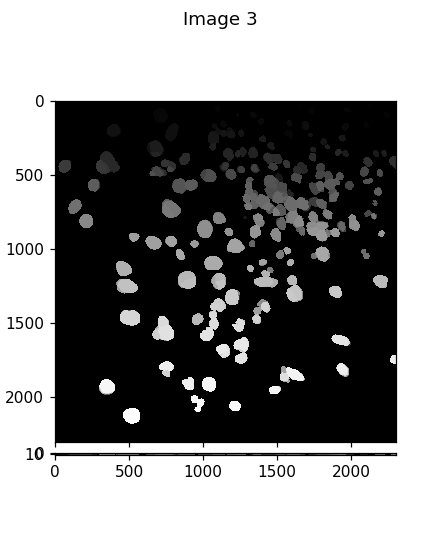

In [20]:
%matplotlib notebook
imshow_mark_3d([_dapi_im, _polyt_im, labels3d, corr_labels3d])

In [23]:
# Copy segmentation labels
data_master_folder = r'/lab/weissman_imaging/puzheng/MERFISH_data'
analysis_master_folder = r'/lab/weissman_imaging/puzheng/MERFISH_analysis'
print(os.listdir(data_master_folder))


['20230623-KPtumor_C2', '20240118-4T1F171_MF4', '20231004-4T1F170_MF2', '20240123-msBrainP1_MF5', '20231230-4T1preEditTop8_MF4dna', '20240108-4T1F171_MF4', '20240117-msBrainP1_MF5']


In [24]:
experiment_date = os.path.basename(data_folder).split('-')[0]
print(experiment_date)
for _fd in os.listdir(data_master_folder):
    if experiment_date in _fd:
        break
analysis_folder = os.path.join(analysis_master_folder, _fd)
print(analysis_folder)

20240123
/lab/weissman_imaging/puzheng/MERFISH_analysis/20240123-msBrainP1_MF5


In [25]:
from shutil import copyfile

In [26]:
# manually select data to be transferred:
segmentation_target_folder = os.path.join(analysis_folder, 'CellPoseSegment', 'segmentation_label')
print(segmentation_target_folder)
if not os.path.exists(segmentation_target_folder):
    os.makedirs(segmentation_target_folder)
# copy
seg_label_filenames = [os.path.join(segmentation_save_folder, _f) 
                       for _f in os.listdir(segmentation_save_folder) 
                       if 'segmentation_label' in _f and '.npy' in _f]

for _f in seg_label_filenames:
    print(os.path.basename(_f))
    copyfile(_f, os.path.join(segmentation_target_folder, os.path.basename(_f)))

/lab/weissman_imaging/puzheng/MERFISH_analysis/20240123-msBrainP1_MF5/CellPoseSegment/segmentation_label
segmentation_label_0.npy
segmentation_label_325.npy
segmentation_label_326.npy
segmentation_label_1.npy
segmentation_label_2.npy
segmentation_label_3.npy
segmentation_label_4.npy
segmentation_label_5.npy
segmentation_label_6.npy
segmentation_label_7.npy
segmentation_label_8.npy
segmentation_label_9.npy
segmentation_label_10.npy
segmentation_label_11.npy
segmentation_label_12.npy
segmentation_label_13.npy
segmentation_label_14.npy
segmentation_label_15.npy
segmentation_label_16.npy
segmentation_label_17.npy
segmentation_label_18.npy
segmentation_label_19.npy
segmentation_label_20.npy
segmentation_label_21.npy
segmentation_label_22.npy
segmentation_label_23.npy
segmentation_label_24.npy
segmentation_label_25.npy
segmentation_label_26.npy
segmentation_label_27.npy
segmentation_label_28.npy
segmentation_label_29.npy
segmentation_label_30.npy
segmentation_label_31.npy
segmentation_label_

segmentation_label_302.npy
segmentation_label_303.npy
segmentation_label_304.npy
segmentation_label_305.npy
segmentation_label_306.npy
segmentation_label_307.npy
segmentation_label_308.npy
segmentation_label_309.npy
segmentation_label_310.npy
segmentation_label_311.npy
segmentation_label_312.npy
segmentation_label_313.npy
segmentation_label_314.npy
segmentation_label_315.npy
segmentation_label_316.npy
segmentation_label_317.npy
segmentation_label_318.npy
segmentation_label_319.npy
segmentation_label_320.npy
segmentation_label_321.npy
segmentation_label_322.npy
segmentation_label_323.npy
segmentation_label_324.npy
segmentation_label_327.npy
segmentation_label_328.npy
segmentation_label_329.npy
segmentation_label_330.npy
segmentation_label_331.npy
segmentation_label_332.npy
segmentation_label_333.npy
segmentation_label_334.npy


In [27]:
len(seg_label_filenames)

335

In [35]:
?copyfile

# STEP2: Watershed: Optional, potentially make it worse

In [11]:
watershed_th = 1.6

for _fov_id, _fov_name in enumerate(fovs):
    

    _save_id = _fov_id 
    
    seg_save_file = os.path.join(segmentation_save_folder, f'segmentation_label_{_save_id}.npy')
    watershed_save_file = os.path.join(watershed_folder, f'segmentation_label_{_save_id}.npy')
    if os.path.exists(watershed_save_file):
        print(f"{watershed_save_file} already exists, skip")
        continue
    # Load segmentation
    if os.path.isfile(seg_save_file):
        print(f"- directly load seg from: {seg_save_file}")
        corr_labels3d = np.load(seg_save_file)
    else:
        print(f"- seg file: {seg_save_file} has not been generated yet, skip. ")
        continue
        
    ref_image_file = os.path.join(data_folder, dapi_info['hyb'], _fov_name)
    polyt_image_file = os.path.join(data_folder, polyt_info['hyb'], _fov_name)
    print(f"reference image: {ref_image_file}")
    print(f"PolyT and DAPI image: {polyt_image_file}")
    # load reference DAPI
    _ref_cls = DaxProcesser(ref_image_file, CorrectionFolder=correction_folder, 
                            FiducialChannel=fiducial_channel, DapiChannel=dapi_info['channel'])
    _ref_cls._load_image(sel_channels=[fiducial_channel,dapi_info['channel']])
    _ref_cls._corr_illumination()
    _ref_im = _ref_cls.im_488
    
    # load polyT and DAPI
    _cls = DaxProcesser(polyt_image_file, CorrectionFolder=correction_folder, 
                        FiducialChannel=fiducial_channel)
    _cls._load_image(sel_channels=[polyt_info['channel'],fiducial_channel])
    _cls._corr_illumination()
    _cls._calculate_drift(_ref_im)
    _cls._corr_warpping_drift_chromatic(correction_channels=[polyt_info['channel']], corr_chromatic=False) # removed 405 to increase efficiency
    # extract images
    _dapi_im = copy(getattr(_ref_cls, f"im_{dapi_info['channel']}"))
    _polyt_im = copy(getattr(_cls, f"im_{polyt_info['channel']}"))
    
    
    _save_id = _fov_id 

    dapi_im = Align_Segmentation._correct_image3D_by_microscope_param(_dapi_im, microscope_params)
    polyt_im = Align_Segmentation._correct_image3D_by_microscope_param(_polyt_im, microscope_params)

    # Prepare watershed
    print(f"- run watershed", end=' ')
    _watershed_start = time.time()
    water_input_im = polyt_im
    waterIm, waterMask = watershed.prepare_watershed_images(water_input_im, watershed_th)
    waterMask[corr_labels3d > 0] = True
    waterMask = ndimage.binary_dilation(waterMask, structure=morphology.ball(1))
    # watershed
    new_labels = segmentation.watershed(
                    waterIm, corr_labels3d, mask=waterMask,
                    connectivity=np.ones((3, 3, 3)), watershed_line=True)
    print(f"in {time.time()-_watershed_start:.3f}s.")

    # save
    # save this segmentation mask
    print(f"- save to file: {watershed_save_file}")
    #np.save(watershed_save_file.split('.npy')[0], new_labels, )
    
    break

- directly load seg from: \\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\Segmentation\segmentation_label_0.npy
reference image: \\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\H0M1\Conv_zscan_000.dax
PolyT and DAPI image: \\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\H19R1\Conv_zscan_000.dax
Initialize DaxProcesser for file:\\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\H0M1\Conv_zscan_000.dax
- New save file: \\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\H0M1\Conv_zscan_000_processed.hdf5
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488', '405'] in 1.732s.
- Correct illumination for channels: ['488', '405']
-- Keep channels: ['488', '405'] for corr_illumination.
- Start illumination correction for channels:[

<IPython.core.display.Javascript object>


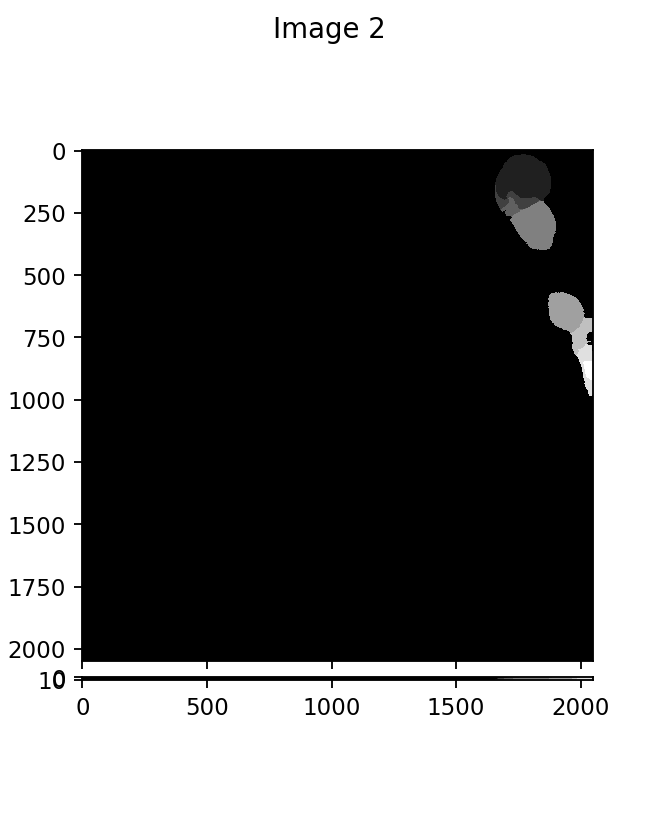

In [203]:
imshow_mark_3d([new_labels, corr_labels3d])

## visualize merlin_output_tif

In [12]:
import tifffile
ims = tifffile.imread(r'Z:\MERFISH_analysis\20230513-wtBrain_MO4\FiducialCorrelationWarp\images\aligned_fiducial_images30.tif')